In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
import warnings
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import ttest_ind
from sklearn.preprocessing import normalize
from sklearn.compose import TransformedTargetRegressor
import pickle
import os
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_squared_error as R2
from sklearn.metrics import mean_absolute_error as mae
warnings.filterwarnings('ignore')

# Procesamiento de los datos

In [2]:
#Leer los dataframes
Meteo=pd.read_csv("UH_2023/DATOS_METEO.TXT", sep="|")
Eto=pd.read_csv("UH_2023/DATOS_ETO.TXT", sep="|")
df=pd.read_csv("UH_2023/UH_2023_TRAIN.txt", sep="|")

In [3]:
#Cambiar el formato de la fecha y extraer el año
Meteo["validTimeUtc"]=pd.to_datetime(Meteo["validTimeUtc"])
Meteo["Year"]=Meteo["validTimeUtc"].dt.strftime('%Y')
Meteo["Month"]=Meteo["validTimeUtc"].dt.strftime('%m')
Eto["date"]=pd.to_datetime(Eto["date"], format='%Y%m%d')
Eto["Year"]=Eto["date"].dt.strftime('%Y')
Eto["Month"]=Eto["date"].dt.strftime('%m')
df["Year"]=2000+df["CAMPAÑA"]
#Eliminamos las fechas porque no nos interesan
df.drop("CAMPAÑA", axis=1, inplace=True)
Eto.drop("date", axis=1, inplace=True)
Meteo.drop("validTimeUtc", axis=1, inplace=True)
#Cambiamos el formato de la altitud
df["ALTITUD"]=df["ALTITUD"].str.slice(0, 3)
#Anotamos cada mes para luego obtener los datos del año anterior al punto de predicción
etapas_cultivo=['01','02','03','04','05','06']
meses_año_anterior=['12','11','10','09','08','07']

Con esta función pretendemos extraer y agrupar los datos que serán de interés para la predicción, para realizar el entrenamiento, nos quedaremos con **la información de las parcelas y los datos meteorológicos, agrupados por año (desde junio del año a predecir hasta julio del año anterior, ajustándonos así a los datos que tenemos de la campaña de 2022 y ajustandonos también al ciclo anual de producción de la uva**. Se usan también los valores de producción y superficie para la finca y variedad en los ultimos 2 años para tener una concepción en el caso de haber métricas de la progesión de las fincas año a año.

In [4]:
def Agrupate_By_Year(last_year=2021, df=df, Eto=Eto, Meteo=Meteo):
    df_merged=df[df["Year"]==(last_year)].set_index(["ID_FINCA","VARIEDAD"])[['ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'MODO',
       'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION', "Year"]]
    print("df_merged", df_merged.shape)
    for n in range(1,3):
        df_year=df[df["Year"]==(last_year-n)].groupby(["ID_FINCA", "VARIEDAD"]).sum()[['PRODUCCION', 'SUPERFICIE']]
        #Calculamos la rentabilidad de las parcelas de cada estación meteorológica en los años enteriores
        year="-"+str(n)
        df_merged=df_merged.merge(df_year, suffixes=('',year), on=["ID_FINCA", "VARIEDAD"], how="left")
        print("df_merged años prod", df_merged.shape)
    #Generamos agregados anuales de las diferentes condiciones climatológicas
    df_eto=Eto[Eto["Year"]==(str(last_year))].groupby(["ID_ESTACION"]).aggregate(['mean'])
    #También generaremos los agregados para cada etapa del cultivo de la vid
    for items in etapas_cultivo:
        prueba=Eto[(Eto["Year"]==(str(last_year))) & (Eto["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_eto=df_eto.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    for items in meses_año_anterior:
        prueba=Eto[(Eto["Year"]==(str(last_year-1))) & (Eto["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_eto=df_eto.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    df_merged=df_merged.reset_index().merge(df_eto, on="ID_ESTACION")
    print("df_merged eto", df_merged.shape)
    #Generamos agregados anuales de las diferentes condiciones climatológicas
    df_meteo=Meteo[Meteo["Year"]==(str(last_year))].groupby(["ID_ESTACION"]).aggregate(['mean'])
    #También generaremos los agregados para cada etapa del cultivo de la vid
    for items in etapas_cultivo:
        prueba=Meteo[(Meteo["Year"]==(str(last_year))) & (Meteo["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_meteo=df_meteo.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    for items in meses_año_anterior:
        prueba=Meteo[(Meteo["Year"]==(str(last_year-1))) & (Meteo["Month"]==(items))].groupby(["ID_ESTACION"]).aggregate(['mean'])
        df_meteo=df_meteo.merge(prueba, on="ID_ESTACION", suffixes=('',items))
    df_merged=df_merged.merge(df_meteo, on="ID_ESTACION")
    print("df_merged meteo", df_merged.shape)
    return(df_merged)

# Modelo para rellenar los valores de Superficie

Dado la cruzial importancia de la superficie a la hora de predecir la producción y al no estar anotados los datos de superficie para los años anteriores a 2020, realizaremos un modelo de **RandomForest** para la predicción de los valores restantes de superficie y poder así usarlos en el modelo de predicción de la producción.

In [5]:
#Fincas en las que sí que se ha anotado los metros de superficie
df_sup=df[(df["SUPERFICIE"]!=0) & (df["PRODUCCION"].notna())]

In [6]:
df_sup
superficie=df_sup.pop("SUPERFICIE")
X_train, X_test, y_train, y_test = train_test_split(df_sup, superficie, test_size=0.33, random_state=1)
variables=X_train.columns
cat_variables=['ID_FINCA','VARIEDAD','ID_ZONA','ID_ESTACION','MODO','TIPO','COLOR', "ALTITUD"]
variables=variables.drop(cat_variables).to_list()

In [7]:
#Pipeline para el procesamiento de variables categóricas
categoricas= Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value="None")), 
                     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
#Pipeline para el procesamiento de variables numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('scaler', StandardScaler())])

hack_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, variables),
        ('cat', categoricas, cat_variables)])

In [8]:
hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', RandomForestRegressor())])

In [9]:
#Entrenamiento del modelo
parameters={'clas__bootstrap': [True], 'clas__max_depth': [100], 'clas__max_features': ['auto'], 
            'clas__min_samples_leaf': [1],'clas__min_samples_split': [2], 'clas__n_estimators': [600]}

hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', RandomForestRegressor())])

GS = GridSearchCV(hack_pipe_RF, param_grid=parameters, cv=5, verbose=10, scoring='neg_root_mean_squared_error')
GS.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600
[CV 1/5; 1/1] END clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600; total time=   8.9s
[CV 2/5; 1/1] START clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600
[CV 2/5; 1/1] END clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600; total time=   8.6s
[CV 3/5; 1/1] START clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto, clas__min_samples_leaf=1, clas__min_samples_split=2, clas__n_estimators=600
[CV 3/5; 1/1] END clas__bootstrap=True, clas__max_depth=100, clas__max_features=auto,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PRODUCCION',
                                                                          'Year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                        

In [10]:
print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

Mejor score:  -1.5399518451161165
Mejor configuración de parámetros:  {'clas__bootstrap': True, 'clas__max_depth': 100, 'clas__max_features': 'auto', 'clas__min_samples_leaf': 1, 'clas__min_samples_split': 2, 'clas__n_estimators': 600}


In [11]:
RF_superficie = GS.best_estimator_
y_pred=RF_superficie.predict(X_test)

In [12]:
print("El modelo tiene un valor de r2 para la predicción de la superficie de: ", r2_score(y_test, y_pred))

El modelo tiene un valor de r2 para la predicción de la superficie de:  0.7467506749685746


Con este modelo de RandomForest parece que tenemos la capacidad de inferir (aunque sea en parte) un tamaño aproximado de las parcelas en las que no había sido anotada su superficie, puediendo usar esa variable en el entrenamiento del modelo de predicción de la producción.

In [13]:
RF_superficie.fit(df_sup, superficie)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PRODUCCION', 'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEn

In [14]:
#Predecimos los valores de superficie
df_sup_0=df[(df["SUPERFICIE"]==0) & (df["PRODUCCION"].notna())]

In [15]:
#Realizamos la predicción
df_sup_0["SUPERFICIE"]=RF_superficie.predict(df_sup_0.drop("SUPERFICIE", axis=1))

In [16]:
#Juntamos ambos dataframes
df=pd.concat([df[(df["SUPERFICIE"]!=0)], df_sup_0])
df

ID_FINCA  ID_ZONA  ID_ESTACION ALTITUD  VARIEDAD  MODO  TIPO  COLOR  \
6476     48626      302           13     600        32     2     0      1   
6477     47921      302           13     600        32     2     0      1   
6478      5696      919           14     650        59     1     0      1   
6480     98814      919           14     650        32     2     0      1   
6481     98814      919           14     650        40     2     0      1   
...        ...      ...          ...     ...       ...   ...   ...    ...   
7530     13054      464           14     650        59     2     0      1   
7535     16692      464           14     650        59     2     0      1   
7536     78846      464           14     650        59     2     0      1   
7537     59317      464           14     650        59     2     0      1   
7563     13439      428           14     730        32     2     0      1   

      SUPERFICIE  PRODUCCION  Year  
6476    3.750300   19511.107  2020  
6477    7.373500   38678.893  2020  
6478    7.620000    7092.800  2020  
6480    7.165700    6660.000  2020  
6481    3.500000    6970.000  2020  
...          ...         ...   ...  
7530    2.356716    6432.335  2021  
7535    0.921176    2007.876  2021  
7536    0.954735    2460.471  2021  
7537    0.921176    2005.133  2021  
7563    0.777137    2509.455  2021  

[9592 rows x 11 columns]

In [17]:
#Guardar el modelo y los resultados
filename = 'Models/RF_superficie.sav'
pickle.dump(RF_superficie, open(filename, 'wb'))

# **Desarrollo del modelo de machine learning** 

Dado al reducido número de muestras y la importancia de la explicabilidad en el modelo, utilizaremos
modelos de machine learning clásicos, basados en **Random Forest** en lugar de modelos complejos de
redes neuronales los cuales padecen del efecto caja negra que impiden hacer uso del modelo más allá
de la predicción de los valores.

## Pre-processing pipeline
Generaremos un pipeline de preprocesamiento, codificando como variables categóricas mediante un _"OneHotEncoder"_ las variables 'ID_FINCA', 'VARIEDAD', 'ID_ZONA', 'ID_ESTACION', 'MODO', 'TIPO', 'ALTITUD' y 'COLOR'. Las demás variables serán estandarizadas mediante un _"StandardScaler"_ para evitar así que algunas variables tengan mayor peso en el entrenamiento que otras.

In [18]:
# DataFrame con los resultados
# Si no se han generado ningún resultado lo genera.
if not os.path.isfile("results.csv"):
    results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
# Si se habían generado anteriormente, y el archivo está disponible, lo lee. 
else:
    results=pd.read_csv("results.csv", index_col=0)

#Función para el análisis del desempeño de los modelos
def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    print('Score done')
    test_r2 = model.score(X_test, y_test)
    print('Score 2 done')
    # Calcula el error    
    train_mae = mean_absolute_error(y_train, model.predict(X_train))
    test_mae = mean_absolute_error(y_test, model.predict(X_test))
    # Muetra los resultados en formato legible
    print('Training \t\t Test')
    print('-------- \t\t ----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    results.loc[description]= (train_r2, test_r2, train_mae, test_mae)

Utilizaremos para el entrenamiento, los datos agregados desde 2016 a 2020, usando los datos de 2021 como conjunto de validación, de esta manera tendremos una aproximación que sea lo más similar posible al uso productivo que se le dará a la herramienta, utilizando los valores de años anteriores para la predicción de la campaña actual de produccion. Los datos de 2014 y 2015 fueron descartados al no tener información precisa de algunos de los meses.

In [19]:
#Utilizamos la función generada para crear el dataframe que usaremos en entrenamiento, centrado en el año 2021
X_2020=Agrupate_By_Year(last_year=2020, df=df, Eto=Eto, Meteo=Meteo)
X_2019=Agrupate_By_Year(last_year=2019, df=df, Eto=Eto, Meteo=Meteo)
X_2018=Agrupate_By_Year(last_year=2018, df=df, Eto=Eto, Meteo=Meteo)
X_2017=Agrupate_By_Year(last_year=2017, df=df, Eto=Eto, Meteo=Meteo)
X_2016=Agrupate_By_Year(last_year=2016, df=df, Eto=Eto, Meteo=Meteo)
X_train=pd.concat([X_2020,X_2019,X_2018,X_2017,X_2016])
X_test=Agrupate_By_Year(last_year=2021, df=df, Eto=Eto, Meteo=Meteo)
#Eliminamos los casos en los que la producción es menor que el percentil 1 ya que son outlyiers
X_train=X_train[X_train["PRODUCCION"]>X_train["PRODUCCION"].quantile(q=0.01)]

#Separamos los datos de entrenamiento y test que serán usados para evaluar nuestro modelo
y_train=X_train.pop("PRODUCCION")
y_test=X_test.pop("PRODUCCION")
variables=X_train.columns
cat_variables=['ID_FINCA','VARIEDAD','ID_ZONA','ID_ESTACION','MODO','TIPO','COLOR', "ALTITUD"]
variables=variables.drop(cat_variables).to_list()
print(f' dataset train has {X_train.shape}')
print(f' dataset test has {X_test.shape}')

df_merged (1006, 9)
df_merged años prod (1006, 11)
df_merged años prod (1006, 13)
df_merged eto (1006, 3564)
df_merged meteo (1006, 3967)
df_merged (1055, 9)
df_merged años prod (1055, 11)
df_merged años prod (1055, 13)
df_merged eto (1055, 3564)
df_merged meteo (1055, 3967)
df_merged (1061, 9)
df_merged años prod (1061, 11)
df_merged años prod (1061, 13)
df_merged eto (1061, 3564)
df_merged meteo (1061, 3967)
df_merged (1017, 9)
df_merged años prod (1017, 11)
df_merged años prod (1017, 13)
df_merged eto (1017, 3564)
df_merged meteo (1017, 3967)
df_merged (1079, 9)
df_merged años prod (1079, 11)
df_merged años prod (1079, 13)
df_merged eto (1079, 3564)
df_merged meteo (1079, 3967)
df_merged (1044, 9)
df_merged años prod (1044, 11)
df_merged años prod (1044, 13)
df_merged eto (1044, 3564)
df_merged meteo (1044, 3967)
 dataset train has (5165, 3966)
 dataset test has (1044, 3966)


In [20]:
#Pipeline para el procesamiento de variables categóricas
categoricas= Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=None)), 
                     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
#Pipeline para el procesamiento de variables numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                             ('scaler', StandardScaler())])

hack_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, variables),
        ('cat', categoricas, cat_variables)])

In [ ]:
from xgbtune import tune_xgb_model
X_train_transformed=hack_trans.fit_transform(X_train)
params = {'eval_metric': 'mae'}
params, round_count = tune_xgb_model(params, X_train_transformed, y_train)

tuning pass 0...
computing best round...
best round: 91
tuning max_depth and min_child_weight ...
best loss: 536.8902
best max_depth: 8
best min_child_weight: 2
tuning gamma ...
best loss: 536.8902
best gamma: 0.0
re-computing best round...
best round: 91
tuning subsample and colsample_bytree ...


Best marams tune_xgb_model
{'eval_metric': 'rmsle', 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 0, 'lambda': 1, 'seed': 0}

In [25]:
import xgboost as xgb
XGB = xgb.XGBRegressor(**params)
XGB = TransformedTargetRegressor(regressor=XGB, func=np.log1p, 
                                inverse_func=np.expm1)
hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', XGB)], verbose=10)

hack_pipe_RF.fit(X_train, y_train)

description = 'Random forest para la predicción producción vinícola con modelo para superficie sin out'

[Pipeline] .............. (step 1 of 2) Processing prep, total=   0.9s
[Pipeline] .............. (step 2 of 2) Processing clas, total=  32.4s


In [26]:
show_results(description, hack_pipe_RF, X_train, y_train, X_test, y_test)

Score done
Score 2 done
Training 		 Test
-------- 		 ----
R² = 0.977		R² = 0.726
MAE = 1020.57					MAE = 3913.95


In [27]:
#Guardar el modelo y los resultados
filename = 'Models/XGBoost_produccion_log1p_out001.sav'
pickle.dump(hack_pipe_RF, open(filename, 'wb'))
results.to_csv("results.csv")

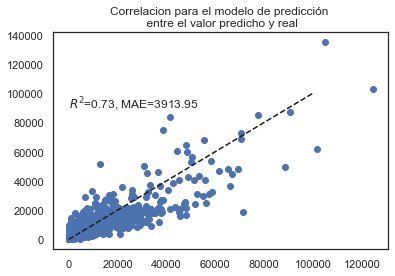

In [29]:
#Correlacion entre el valor predicho y real en el conjunto de test tras realizar la transformada log1p
y_pred = hack_pipe_RF.predict(X_test)
plt.scatter(y_test, y_pred)
plt.title("Correlacion para el modelo de predicción \n entre el valor predicho y real")
plt.text(100, 90000, r'$R^2$=%.2f, MAE=%.2f' % (
    0.726, 3913.95))
plt.plot([0, 100000], [0, 100000], '--k')

In [32]:
from sklearn.model_selection import StratifiedGroupKFold 
from flaml import AutoML
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'mae',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune XGBoost in this example
    "task": 'regression',  # task type
    "log_file_name": 'houses_experiment.log',  # flaml log file
    "seed": 7654321,  # random seed
}
automl = AutoML(**settings)

automl = TransformedTargetRegressor(regressor=automl, func=np.log1p, 
                                inverse_func=np.expm1)
hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', automl)], verbose=10)

hack_pipe_RF.fit(X_train, y_train)

ImportError: cannot import name 'StratifiedGroupKFold' from 'sklearn.model_selection' (/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/__init__.py)

El modelo tiene cierta tendencia al subajuste, generando predicciones menores que el resultado real, para ello vamos a cambiar el peso que damos a las muestras en entrenamiento, generando un vector que normalize la producción de la finca, dando más énfasis en entrenamiento a los datos en los que la producción ha sido mayor y multiplicando por un escalar en función del año en el que se realizó la campaña, dando así también mayor peso a los datos más nuevos con respecto a los más antiguos.

In [104]:
#Cálculo del peso de las muestras según el año
wiegting={2016:1, 2017:2, 2018:3, 2019:4, 2020:5}
samp_weights=X_train["Year"].replace(wiegting)
#Cálculo del peso de las muestras según el valor de producción
normalized_prod=pd.Series(normalize([y_train]).tolist()[0])
#Cálculo del peso conjunto teniendo en cuenta el año y el valor de producción
df_weight=pd.DataFrame([normalized_prod.values,samp_weights.values]).T
df_weight["W"]=df_weight[0]*df_weight[1]
samp_weights=df_weight["W"].values.tolist()

In [105]:
RF = RandomForestRegressor(bootstrap=True, max_depth=20, max_features='auto',
                            min_samples_leaf=4, min_samples_split=5, n_estimators=200)
RF = TransformedTargetRegressor(regressor=RF, func=np.log1p, 
                                inverse_func=np.expm1)
hack_pipe_RF = Pipeline([('prep', hack_trans),
                         ('clas', RF)], verbose=10)

hack_pipe_RF.fit(X_train, y_train, clas__sample_weight=samp_weights)

description = 'Random forest para la predicción producción vinícola con modelo para superficie sin out 0.01, samp_weights'

[Pipeline] .............. (step 1 of 2) Processing prep, total=   0.9s
[Pipeline] .............. (step 2 of 2) Processing clas, total= 6.7min


In [106]:
show_results(description, hack_pipe_RF, X_train, y_train, X_test, y_test)

Score done
Score 2 done
Training 		 Test
-------- 		 ----
R² = 0.950		R² = 0.805
MAE = 1349.43					MAE = 3345.83


In [107]:
#Guardar el modelo y los resultados
filename = 'Models/RF_produccion_log1p_out001_sampweightyearprod.sav'
pickle.dump(hack_pipe_RF, open(filename, 'wb'))
results.to_csv("results.csv")

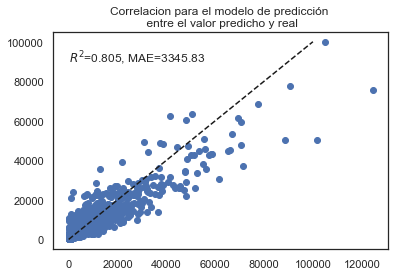

In [109]:
#Correlacion entre el valor predicho y real en el conjunto de test tras realizar la transformada log1p
y_pred = hack_pipe_RF.predict(X_test)
plt.scatter(y_test, y_pred)
plt.title("Correlacion para el modelo de predicción \n entre el valor predicho y real")
plt.text(100, 90000, r'$R^2$=%.3f, MAE=%.2f' % (
    0.805, 3345.83))
plt.plot([0, 100000], [0, 100000], '--k')

In [36]:
hack_pipe_RF = pickle.load(open("Models/RF_produccion.sav", 'rb'))

In [38]:
print("El modelo de la fase local tenía un valor de RMSE para la predicción de la producción de: \n", R2(y_test, hack_pipe_RF.predict(X_test)))
print("El modelo de la fase local tenía un valor de mae para la predicción de la producción de: \n", mae(y_test, hack_pipe_RF.predict(X_test)))

El modelo de la fase local tenía un valor de RMSE para la predicción de la producción de: 
 50940587.96010296
El modelo de la fase local tenía un valor de mae para la predicción de la producción de: 
 3700.910315411387


In [39]:
hack_pipe_RF = pickle.load(open("Models/RF_produccion_log1p_out001_sampweightyearprod.sav", 'rb'))

In [40]:
print("El modelo actual tiene un valor de RMSE para la predicción de la producción de: \n", R2(y_test, hack_pipe_RF.predict(X_test)))
print("El modelo tiene un valor de mae para la predicción de la producción de: \n", mae(y_test, hack_pipe_RF.predict(X_test)))

El modelo actual tiene un valor de RMSE para la predicción de la producción de: 
 36232317.44308811
El modelo tiene un valor de mae para la predicción de la producción de: 
 3344.460581370384


Podemos observar una mejoría notable en el modelo con respecto al presentado en la fase local, la introducción de la tranformación logarítmica y la introducción del peso de las muestras para aumentar el peso de los valores más actuales y con mayor producción han conseguido una mejoría sobre el conjunto de test del 29% respecto al **RMSE** y del 10% con respecto al **MAE**

In [60]:
#Estudiar como el modelo funciona a la hora de agregar por parcela
X_test["PRODUCCION"]=y_test
X_test["PRODUCCION_pred"]=hack_pipe_RF.predict(X_test.drop("PRODUCCION",axis=1))
X_test_finca=X_test.groupby("ID_FINCA").sum()[["PRODUCCION","PRODUCCION_pred"]]
print("El modelo tiene un valor de r2 para la predicción de la producción de: ", 
      r2_score(X_test_finca["PRODUCCION"], X_test_finca["PRODUCCION_pred"]))
print("El modelo tiene un valor de MAE para la predicción de la producción de: ", 
      mean_absolute_error(X_test_finca["PRODUCCION"], X_test_finca["PRODUCCION_pred"]))

El modelo tiene un valor de r2 para la predicción de la producción de:  0.8761048922382588
El modelo tiene un valor de MAE para la predicción de la producción de:  3925.303648609455


    Podemos observar que el desempeño del modelo es mayor cuando llega la hora de agrupar por fincas y calcular la producción total de cada una de las fincas, teniendo en este caso un valor de r2 de 0.87 y MAE de 3925.30

In [61]:
hack_pipe_RF = pickle.load(open("Models/RF_produccion_log1p_out001_sampweightyearprod.sav", 'rb'))
#Entrenamos el modelo haciendo uso de todos los datos
X_train_2=pd.concat([X_2020,X_2019,X_2018,X_2017,X_2016, X_test.drop("PRODUCCION_pred",axis=1)])
#Eliminamos los casos en los que la producción excede el percentil 99 ya que son outlyiers que pueden complicar el entrenamiento del modelo
X_train_2=X_train_2[X_train_2["PRODUCCION"]>X_train_2["PRODUCCION"].quantile(q=0.01)]
#Separamos los datos de entrenamiento y test que serán usados para evaluar nuestro modelo
y_train_2=X_train_2.pop("PRODUCCION")

In [66]:
#Cálculo de los pesos para el entrenamiento
wiegting={2016:1, 2017:2, 2018:3, 2019:4, 2020:5, 2021:6}
samp_weights=X_train_2["Year"].replace(wiegting)
normalized_prod=pd.Series(normalize([y_train_2]).tolist()[0])
df_weight=pd.DataFrame([normalized_prod.values,samp_weights.values]).T
df_weight["W"]=df_weight[0]*df_weight[1]
samp_weights=df_weight["W"].values.tolist()

In [67]:
hack_pipe_RF.fit(X_train_2, y_train_2, clas__sample_weight=samp_weights)

[Pipeline] .............. (step 1 of 2) Processing prep, total=   1.5s
[Pipeline] .............. (step 2 of 2) Processing clas, total= 8.9min


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SUPERFICIE', 'Year',
                                                   'PRODUCCION-1',
                                                   'SUPERFICIE-1',
                                                   'PRODUCCION-2',
                                                   'SUPERFICIE-2',
                                                   ('DewpointLocalAfternoonAvg',
                                                    'mean'),
                                                   ('DewpointLocalAfternoonMax',
  

In [68]:
#Guardar el modelo completo
filename = 'Models/RF_produccion_log1p_out001_sampweightyearprod_completo.sav'
pickle.dump(hack_pipe_RF, open(filename, 'wb'))

#### Predicción de los valores de 2022

In [70]:
X_2022=Agrupate_By_Year(last_year=2022, df=df, Eto=Eto, Meteo=Meteo)
X_2022.drop("PRODUCCION", axis=1, inplace=True)
X_2022["PRODUCCION"]=hack_pipe_RF.predict(X_2022)
X_2022=X_2022[["ID_FINCA", "VARIEDAD","MODO", "TIPO", "COLOR", "SUPERFICIE", "PRODUCCION"]]

df_merged (1066, 9)
df_merged años prod (1066, 11)
df_merged años prod (1066, 13)
df_merged eto (1066, 3564)
df_merged meteo (1066, 3967)


In [71]:
X_2022

ID_FINCA  VARIEDAD  MODO  TIPO  COLOR  SUPERFICIE    PRODUCCION
0        48626        32     2     0      1      3.7503  21599.763447
1        47921        32     2     0      1      7.3735  49764.897302
2         5696        59     1     0      1      7.6200  13250.697863
3        98814        32     2     0      1      3.3267  15865.049893
4        98814        40     2     0      1      2.7724   9361.953260
...        ...       ...   ...   ...    ...         ...           ...
1061     37461        52     2     0      1      3.6800  26576.982092
1062     58769        32     2     0      1      4.2500  33329.025294
1063     58769        59     2     0      1      4.0700  41071.614012
1064     88928        40     2     0      1      4.5727  44518.163893
1065     88928        52     2     0      1      1.6099  10338.804867

[1066 rows x 7 columns]

In [73]:
df2 = X_2022.sort_values(["ID_FINCA", "VARIEDAD", "MODO", "TIPO", "COLOR","SUPERFICIE"],
              ascending = [True, True, True, True, True, True])

In [75]:
df2.to_csv("UH2023_Universidad de Castilla La Mancha (UCLM)_Pistachio_1.txt", sep="|", float_format='%.2f', header=False, index=False)

# Análisis de explicabilidad
Dada la importancia crucial en el proyecto de la explicabilidad de nuestro modelo y dado a la total trasparencia de los modelos de RandomForest, procedimos una vez entrenado el modelo a estudiar en qué basa este la toma de decisiones, para ello hicimos uso de gráficos __shap__ que permiten ver para cada valor de predicción, ver que variables han tenido mayor o menor relevancia en el valor predicho. Para ello nos centramos en los valores más extremos, aquellas 5 muestras con mayor y menor valor de producción predicho por el modelo en 2022.

In [110]:
import shap
shap.initjs()

Seleccionaremos las muestras con los valores mayores y menores para cada una de las variables de interés para hacer los análisis de la predicción.

In [111]:
#Modelo para la predicción de ERK
RF = pickle.load(open("Models/RF_produccion_log1p_out001_sampweightyearprod.sav", 'rb'))
X_2022 = Agrupate_By_Year(last_year=2022, df=df, Eto=Eto, Meteo=Meteo)
y_pred = RF.predict(X_2022.drop("PRODUCCION",axis=1))
#Nos quedaremos con las filas para las que ha predicho un valor mayor y menor de produccion
max_idx=pd.DataFrame(y_pred)[0].nlargest(5).index.to_list()
min_idx=pd.DataFrame(y_pred)[0].nsmallest(5).index.to_list()

df_merged (1066, 9)
df_merged años prod (1066, 11)
df_merged años prod (1066, 13)
df_merged eto (1066, 3564)
df_merged meteo (1066, 3967)


Una cosa que era de esperar es que la muestra con menor valor predicho es a tiempo 0, cosa que podría ser comprensible si los tratamientos llevan a un cierto aumento de los niveles de fosforilación de ERK.

In [112]:
samples=X_2022.iloc[max_idx+min_idx]

In [113]:
explainer = shap.TreeExplainer(RF.named_steps["clas"].regressor_)
sampleID=samples.index

In [114]:
samples=RF.named_steps["prep"].transform(samples.drop(["PRODUCCION"],axis=1))

In [115]:
#Seleccionamos las variables con los nuevos nombres tras el preprocesamiento
new_cat_cols = RF.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"].get_feature_names(cat_variables)
all_cols = np.concatenate([variables, new_cat_cols])

In [153]:
def shap_plot(n, plot="Large"):
    #Estadísiticos shap de la importancia de las variables en la muestra seleccionada
    choosen_instance = samples[n]
    df_shap=pd.DataFrame(choosen_instance).T
    df_shap.columns=all_cols
    shap_values = explainer.shap_values(df_shap)
    #Mostramos las 10 variables con mayor importancia
    prueba_shap=pd.DataFrame(shap_values[0]).T
    prueba_shap.columns=all_cols
    #Seleccionamos si las 10 mayores o las 10 menores según que queramos mostrar
    if plot=="Large":
        print(df_shap[prueba_shap.T[0].nlargest(10).index].T.rename(columns={0:"Valor"}))
    else:
        print(df_shap[prueba_shap.T[0].nsmallest(10).index].T.rename(columns={0:"Valor"}))
    #Gráfico shap
    return shap.force_plot(explainer.expected_value[0], shap_values[0], df_shap)

### Muestras con los valores de predicción más elevados

In [154]:
shap_plot(0)

                                        Valor
SUPERFICIE                           6.580392
PRODUCCION-1                         6.617879
PRODUCCION-2                         8.471188
VARIEDAD_32                          1.000000
MODO_1                               0.000000
MODO_2                               1.000000
(UVIndexLocalDayAvg, mean)          -0.360788
VARIEDAD_59                          0.000000
(PrecipAmountLocalEveningMax, mean) -0.315225
(UVIndexLocalMorningMax, mean)      -0.665484


In [155]:
shap_plot(1)

                                          Valor
SUPERFICIE                             4.844219
PRODUCCION-1                           7.985493
PRODUCCION-2                           6.278434
VARIEDAD_32                            1.000000
MODO_1                                 0.000000
MODO_2                                 1.000000
VARIEDAD_59                            0.000000
(GustLocalOvernightMin05, mean)       -8.196651
(PrecipAmountLocalEveningMax, mean)   -0.336513
(VisibilityLocalAfternoonMin01, mean) -0.644089


In [156]:
shap_plot(2)

                                          Valor
SUPERFICIE                             8.154193
PRODUCCION-1                           5.623580
PRODUCCION-2                           4.362623
MODO_1                                 0.000000
MODO_2                                 1.000000
(UVIndexLocalDayAvg, mean)            -0.242595
(VisibilityLocalAfternoonMin01, mean) -0.777151
(PrecipAmountLocalEveningMax, mean)   -0.021448
(GustLocalOvernightMax05, mean)       -6.542349
(GustLocalOvernightMin05, mean)       -8.196651


In [157]:
shap_plot(3)

                               Valor
SUPERFICIE                  5.023938
PRODUCCION-1                4.705472
PRODUCCION-2                5.062008
VARIEDAD_32                 1.000000
MODO_1                      0.000000
MODO_2                      1.000000
ID_ZONA_510                 1.000000
ID_ESTACION_15              1.000000
VARIEDAD_59                 0.000000
(UVIndexLocalDayAvg, mean)  0.064705


In [158]:
shap_plot(4)

                                          Valor
SUPERFICIE                             2.400228
PRODUCCION-1                           4.140109
PRODUCCION-2                           6.573433
ID_FINCA_76459                         1.000000
ID_ZONA_510                            1.000000
ALTITUD_560                            1.000000
MODO_1                                 0.000000
MODO_2                                 1.000000
(UVIndexLocalDaytimeAvg08, mean)       1.507898
(VisibilityLocalOvernightMax10, mean) -1.810333


    A partir del análsiis de explicabilidad podemos ver que en las fincas que mayor producción ha predicho el modelo, las variables con mayor importancia son la producción en los años anteriores y la superficie de las fincas. Este hecho era esperable, ya que las fincas que durante los años anteriores estuvieran generando valores muy elevados de producción es esperable que los años siguientes también tengan elevadas producciones de uva. Respecto a la superficie, durante el análsis de los datos ya habíamos predicho la crucial importancia de la superficie de las parcelas a la hora de calcular la producción.

### Muestras con los valores de predicción más reducidos

In [159]:
shap_plot(5, plot="")

                                  Valor
SUPERFICIE                    -0.832377
PRODUCCION-1                  -0.646703
PRODUCCION-2                  -0.609578
MODO_2                         0.000000
MODO_1                         1.000000
VARIEDAD_59                    1.000000
VARIEDAD_87                    0.000000
(windGust01, mean)             0.807028
VARIEDAD_32                    0.000000
(GustLocalEveningMax12, mean) -0.224417


In [160]:
shap_plot(6, plot="")

                                  Valor
SUPERFICIE                    -0.835630
PRODUCCION-1                  -0.647935
PRODUCCION-2                  -0.610323
MODO_2                         0.000000
MODO_1                         1.000000
VARIEDAD_59                    1.000000
VARIEDAD_87                    0.000000
(windGust01, mean)             0.807028
VARIEDAD_32                    0.000000
(GustLocalEveningMax12, mean) -0.224417


In [161]:
shap_plot(7, plot="")

                                  Valor
SUPERFICIE                    -0.829905
PRODUCCION-1                  -0.653881
PRODUCCION-2                  -0.607639
MODO_2                         0.000000
MODO_1                         1.000000
VARIEDAD_59                    1.000000
VARIEDAD_87                    0.000000
(windGust01, mean)             0.807028
VARIEDAD_32                    0.000000
(GustLocalEveningMax12, mean) -0.224417


In [162]:
shap_plot(8, plot="")

                       Valor
SUPERFICIE         -0.836324
PRODUCCION-1       -0.661335
PRODUCCION-2       -0.618371
MODO_1              1.000000
MODO_2              0.000000
VARIEDAD_59         1.000000
ID_ESTACION_3       1.000000
(windGust01, mean)  1.099255
VARIEDAD_32         0.000000
VARIEDAD_87         0.000000


In [163]:
shap_plot(9, plot="")

                                  Valor
SUPERFICIE                    -0.854495
PRODUCCION-1                  -0.655013
PRODUCCION-2                  -0.618465
MODO_2                         0.000000
MODO_1                         1.000000
VARIEDAD_59                    1.000000
VARIEDAD_32                    0.000000
VARIEDAD_87                    0.000000
(GustLocalEveningMax12, mean) -0.492416
(pressureChange11, mean)       1.186794


    Respecto a las muestras con menor valor de predicción en la producción, vemos nuevamente que los valores de superficie y producción en años anteriores son los que mayor peso tienen en la predicción de valores reducidos de producción.

    También parece interesante que algunas variedades de uva parecen tener cierta propensión a valores de predicción más reducidos o elevados, esto puede significar que la productividad de estas variedades es más reducida y eso podría afectar a la rentabilidad de algunas parcelas. Consistentemente, aquellas muestras con mayor predicción fueron aquellas de la variedad 32 y que no eran de la variedad 59, mientras que el caso contrario ocurría en las variables con menor predicción. Por ello se realizó un análisis un poco más profundo del efecto de las variedades de uva con respecto a la producción de las parcelas, prestando especial atención a las variedades 32 y 59 que son las que han aparecido con mayor frecuencia.

Text(0.5, 1.0, 'Produccion según la variedad')

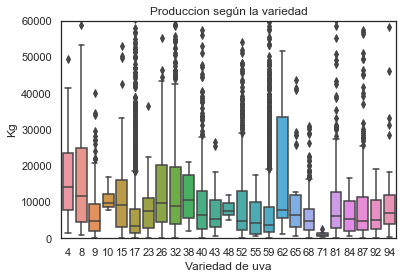

In [132]:
sns.boxplot(data=df, x="VARIEDAD", y="PRODUCCION")
plt.xlabel("Variedad de uva")
plt.ylabel("Kg")
plt.ylim(top=60000, bottom=0)
plt.title("Produccion según la variedad")

In [164]:
data_32 = df[df["VARIEDAD"]==32].copy()
rest_32 = df[df["VARIEDAD"]!=32].copy()
data_59 = df[df["VARIEDAD"]==59].copy()
rest_59 = df[df["VARIEDAD"]!=59].copy()
df_rest = rest_59[rest_59["VARIEDAD"]!=32].copy()
print("Diferencia de la producción de la variedad 32 con respecto al resto")
print(ttest_ind(data_32['PRODUCCION'].dropna(), rest_32['PRODUCCION'].dropna()))
print("Diferencia de la producción de la variedad 59 con respecto al resto")
print(ttest_ind(data_59['PRODUCCION'].dropna(), rest_59['PRODUCCION'].dropna()))

Diferencia de la producción de la variedad 32 con respecto al resto
Ttest_indResult(statistic=14.546247872889102, pvalue=2.2728763701900404e-47)
Diferencia de la producción de la variedad 59 con respecto al resto
Ttest_indResult(statistic=-5.330873779745589, pvalue=1.00243210143956e-07)


<AxesSubplot:xlabel='Variedad', ylabel='PRODUCCION'>

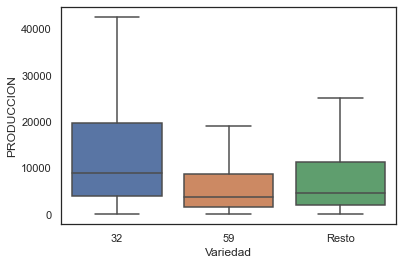

In [169]:
data_32["Variedad"]="32"
data_59["Variedad"]="59"
data_rest["Variedad"]="Resto"
sns.boxplot(data=pd.concat([data_32, data_59, data_rest]), x="Variedad", y="PRODUCCION", showfliers = False)

    Se puede observar que pese a que la diferencia no fue apreciable en el análisis preliminar de las variables, la variedad 32 tiene una mayor productividad produciendo unas mejores cosechas y predicciones más elevadas por parte del modelo, mientras que la variedad 59 tienen una menor productividad y eso se podría tener en cuenta a la hora de desarrollar la estrategia empresarial.

# Conclusión

Mediante el desarrollo de un modelo de predicción de la producción basado en **RandomForest** se llegó a 3 conclusiones principales:

    -El modelo tiene la capacidad de explicar parte de la varianza de la producción de uva, con un desempeño admisible para su uso en la práctica con un MAE de 4376 y un valor de r2 de 0.82 para el conjunto de validación.
    -El análisis de la explicabilidad muestra que los valores de producción de años anteriores, así como los valores de superficie son los que mayor importancia tienen en la producción de las fincas, más allá de los posibles efectos de la meteorología.
    -Un análisis más profundo de los gráficos de explicabilidad han mostrado el efecto positivo y negativo que tienen determinadas variedades de uva (32 y 59).